  ## E: Build & Tune Models

In [1]:
# imports

import pandas as pd
import numpy as np
from patsy import dmatrices

import mlflow # model tracking

from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer

from hyperopt import hp, tpe
from hyperopt.fmin import fmin

#evaluation 
from sklearn import tree
import shap  # package used to calculate Shap values
import matplotlib.pyplot as plt; 


In [2]:
# ### INPUTS ###
retune = False


In [3]:
# start logging

# one time run to create
# mlflow.create_experiement()

mlflow.set_experiment("P1-AnalyzeTrades_f_core")

mlflow.sklearn.autolog()
mlflow.start_run()

mlflow.set_tag('run_id', mlflow.active_run().info.run_id)


In [4]:
# read in data

df_XY = pd.read_csv('output/e_resultcleaned.csv')



In [5]:
# variables

target = 'PCT_RET_FINAL'
variables = [
    # 'UNNAMED:_0', 'UNNAMED:_0_X', 'UNNAMED:_0.1', 'QUANTITY', 'PNL',
    # 'OPEN_PRICE', 'CLOSE_PRICE', 'COMM_TOT', 'QTYCHG', 'PRICE',
    # 'COMMISSION', 'DETAILS', 'STOP', 'DAYSTOFYEND', 'FYEPSNXT',
    'IMPLIED_P_E', 'YEARS_TO_NORMALIZATION', 
    # 'CLOSE_^GSPC', 
    'CLOSE_^VIX',
    # 'UNNAMED:_0_Y', 'AAII_SENT_BULLISH', 'AAII_SENT_NEUTRAL',
    # 'AAII_SENT_BEARISH', 'AAII_SENT_TOTAL', 'AAII_SENT_BULLISH8WEEKMOVAVG',
    'AAII_SENT_BULLBEARSPREAD', 
    # 'AAII_SENT_BULLISHAVERAGE',
    # 'AAII_SENT_BULLISHAVERAGE+STDEV', 'AAII_SENT_BULLISHAVERAGESTDEV',
    # 'AAII_SENT_S&P500WEEKLYHIGH', 'AAII_SENT_S&P500WEEKLYLOW',
    # 'AAII_SENT_S&P500WEEKLYCLOSE', 
    '%_TO_STOP', '%_TO_TARGET',
    'GROWTH_0.5TO0.75', 'ROIC_(BW_ROA_ROE)', 
    # 'IMPLIED_P_E',
    'YEARS_TO_NORMALIZATION', 
    # 'OPEN_DATE', 'CLOSE_DATE', 'SYMBOL',
    # 'OPENACT', 'CLOSEACT', 'DATE', 'ACTION', 'TIME', 'UNNAMED:_6',
    # 'UNNAMED:_8', 'CASH_CHG_(PNL)', 'COMMENTS', 'PCTRETURN', 'STARTDATE',
    # 'COMPANY_NAME_(IN_ALPHABETICAL_ORDER)', 'TICKER', 'CURRENT_PRICE',
    # 'AT_PRICE', 'TARGET', 'EPS1', 'EPS2', 'FYEND', 'LASTUPDATED',
    # 'CATEGORY', 'COMMENTS.1', 'FILENAME', 'DATE_', 'AAII_SENT_DATE',
    # 'PCT_RET_FINAL'
]

dtypes =  pd.Series(df_XY.dtypes)
selected_vars = dtypes[variables]
varlist = []

cols_num = df_XY.select_dtypes(include='number').columns
idx = 0

for v in variables:
    if idx != 0:
        varlist.append('+')

    if v not in cols_num:
        varlist.append('C(')
    
    varlist.append("Q('")
    varlist.append(v)
    varlist.append("')")    
    
    if v not in cols_num:
        varlist.append(')')
    
    idx = idx + 1

varstring = ''.join(varlist)



In [6]:
# Create formula for model

formula =  f""" {target} ~ 1 + {varstring}"""
        
y , X = dmatrices(formula, df_XY, return_type='dataframe')

# TODO save model formula, use this and na transformer
mlflow.log_params({"formula":formula})


In [7]:
# train test data

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)



In [8]:
# tune & run model using hyperopt


# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_absolute_error
# from hpsklearn import HyperoptEstimator
# from hpsklearn import any_regressor
# from hpsklearn import any_preprocessing
# from hyperopt import tpe
# # load dataset
# url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv'
# dataframe = read_csv(url, header=None)
# # split into input and output elements
# data = dataframe.values
# data = data.astype('float32')
# X, y = data[:, :-1], data[:, -1]
# # split into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# # define search
# model = HyperoptEstimator(regressor=any_regressor('reg'), preprocessing=any_preprocessing('pre'), loss_fn=mean_absolute_error, algo=tpe.suggest, max_evals=50, trial_timeout=30)
# # perform the search
# model.fit(X_train, y_train)
# # summarize performance
# mae = model.score(X_test, y_test)
# print("MAE: %.3f" % mae)
# # summarize the best model
# print(model.best_model())


In [9]:
# tune & run model

if retune:
    # https://www.kaggle.com/eikedehling/tune-and-compare-xgb-lightgbm-rf-with-hyperopt

    # def gini(solution, submission):  # actual, expected
    #     """expects 2 lists"""                                       
    #     df = sorted(zip(solution, submission),    
    #             key=lambda x: x[1], reverse=True) # still a list, sorted by y_pred
    #     random = [float(i+1)/float(len(df)) for i in range(len(df))] # uniform percentiles             
    #     totalPos = np.sum([x[0] for x in df]) # sum of actual results                                      
    #     cumPosFound = np.cumsum([x[0] for x in df]) # list of cumulative actual                               
    #     Lorentz = [float(x)/totalPos for x in cumPosFound] # curve                        
    #     Gini = [l - r for l, r in zip(Lorentz, random)] # slice of diff from Lorenz and random                          
    #     return np.sum(Gini)                                                         

    def gini(actual, pred):
        assert (len(actual) == len(pred))
        allv = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)
        allv = allv[np.lexsort((allv[:, 2], -1 * allv[:, 1]))]
        totalLosses = allv[:, 0].sum()
        giniSum = allv[:, 0].cumsum().sum() / totalLosses

        giniSum -= (len(actual) + 1) / 2.
        return giniSum / len(actual)

    # can swap in
    def gini_xgb(predictions, truth):
        truth = truth.get_label()
        return 'gini', -1.0 * gini(truth, predictions) / gini(truth, truth)

    # can swap in
    def gini_lgb(truth, predictions):
        score = gini(truth, predictions) / gini(truth, truth)
        return 'gini', score, True

    def gini_sklearn(truth, predictions):
        return gini(truth, predictions) / gini(truth, truth)

    gini_scorer = make_scorer(gini_sklearn, greater_is_better=True)

    # use hyperopt package with to better search 
    # https://github.com/hyperopt/hyperopt/wiki/FMin
    # use userdefined Gini, as it measures differentiation more
    def objective_gbr(params):
        "objective_gbr function for hyper opt, params is dict of params for mdl"
        parameters = {}
        for k in params:
            parameters[k] = int(params[k])
        mdl = GradientBoostingRegressor(random_state=0, **parameters)
        score = cross_val_score(mdl, X_train, y_train, scoring=gini_scorer, cv=5).mean()
        print("Gini {:.3f} params {}".format(score, parameters))
        return score

    # need to match estimator
    space = {
        'n_estimators': hp.quniform('n_estimators', 450, 500, 5),  # low # high # number of choices
        'max_depth': hp.quniform('max_depth', 9, 10, 2) 
    }

    best_params = fmin(fn=objective_gbr,
                space=space,
                algo=tpe.suggest,
                max_evals=5)

    print("Hyperopt estimated optimum {}".format(best_params))
else:
    best_params = {
        'n_estimators': 500, 
        'max_depth': 10
    }


In [10]:
# fit model 

reg = GradientBoostingRegressor(random_state=0, **best_params)
reg.fit(X_train,y_train)


meters, performance metrics, model artifacts, and lineage information for the current sklearn workflow to the MLflow run with ID '83e1a6b9ad2442379808a71a2779cc28'
2021/01/17 23:45:40 INFO mlflow.utils.autologging_utils: sklearn autologging will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow to the MLflow run with ID '83e1a6b9ad2442379808a71a2779cc28'
2021/01/17 23:45:40 INFO mlflow.utils.autologging_utils: sklearn autologging will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow to the MLflow run with ID '83e1a6b9ad2442379808a71a2779cc28'
2021/01/17 23:45:40 INFO mlflow.utils.autologging_utils: sklearn autologging will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow to the MLflow run with ID '83e1a6b9ad2442379808a71a2779cc28'
2021/01/17 23:45:40 INFO mlflow.utils.autologging_uti

GradientBoostingRegressor(max_depth=10, n_estimators=500, random_state=0)

In [11]:
# validate model

test_score_r2 = reg.score(X_test, y_test) # for GBM is r2

mlflow.log_metric("test_r2", test_score_r2)
print(test_score_r2)


0.3947201067859334


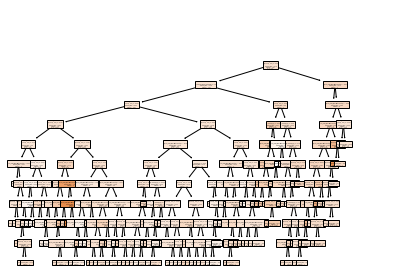

In [12]:
# visualize a single tree

# Get a tree 
sub_tree_1 = reg.estimators_[0, 0]  # pull first 1 estimator, actual regressor vs array

tree.plot_tree(sub_tree_1,
           feature_names = list(X_train.columns),
           filled = True)

plt.tight_layout()
plt.savefig('tree_plot1.png',bbox_inches = "tight")
plt.show()

mlflow.log_artifact('tree_plot1.png')


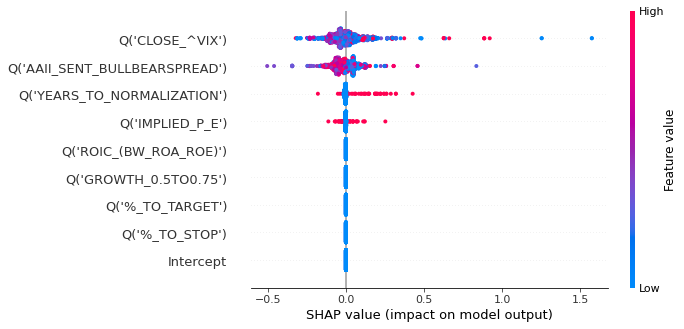

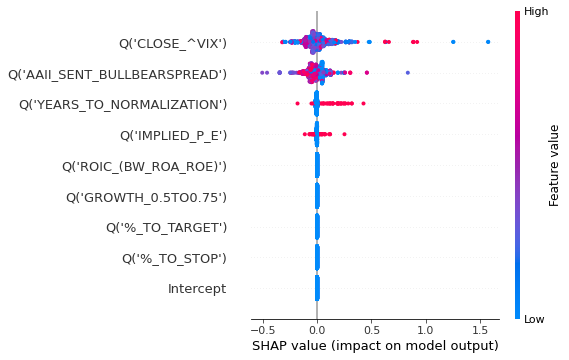

In [13]:
# summarize overall results

# Create object that can calculate shap values
explainer = shap.TreeExplainer(reg)

# save expected value
ev = explainer.expected_value[0]

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_train)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values, X_train)

f = plt.gcf()

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values, X_train,show=False,)
plt.tight_layout()
plt.savefig('summary_plot.png',bbox_inches = "tight")
plt.show()

mlflow.log_metric('expected_val', ev)
mlflow.log_artifact('summary_plot.png')


In [14]:
# check highest 

top_trades = df_XY[df_XY['PCT_RET_FINAL']>1]
top_trades.head()



,Unnamed: 0,UNNAMED:_0,UNNAMED:_0_X,UNNAMED:_0.1,QUANTITY,PNL,OPEN_PRICE,CLOSE_PRICE,COMM_TOT,QTYCHG,...,EPS1,EPS2,FYEND,LASTUPDATED,CATEGORY,COMMENTS.1,FILENAME,DATE_,AAII_SENT_DATE,PCT_RET_FINAL
606,606,606.0,607.0,921.0,5.0,6682.97,600.14000,1937.0100,-2.379502,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,PCM-Tracking - LogHist.csv,2016-04-12,2016-04-14,2.227137
700,700,700.0,701.0,910.0,25.0,3551.17,90.20945,232.3027,-2.878473,400.0,...,NaN,NaN,NaN,NaN,NaN,NaN,PCM-Tracking - LogHist.csv,2016-05-12,2016-05-19,1.574633
740,740,740.0,740.0,1598.0,15.0,4981.36,96.72000,428.8900,-2.191949,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,PCM-Tracking - LogHist.csv,2016-08-05,2016-08-11,3.433526
741,741,741.0,741.0,989.0,10.0,3014.45,96.72000,398.2735,-2.052966,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,PCM-Tracking - LogHist.csv,2016-08-05,2016-08-11,3.116677
819,819,819.0,819.0,1576.0,15.0,2103.98,97.95000,238.3000,-2.269272,75.0,...,NaN,NaN,NaN,NaN,NaN,NaN,PCM-Tracking - LogHist.csv,2016-12-08,2016-12-15,1.432010


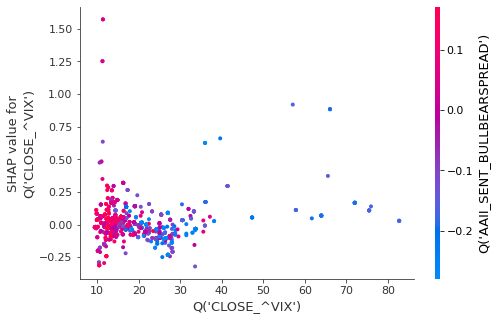

In [15]:
# check top variable(s)

# make plot
shap.dependence_plot("Q('CLOSE_^VIX')", shap_values, X_train)


In [16]:
# end mlflow

mlflow.end_run()
